# Project NLP: Twitter US Airline Sentiment

## Problem Description
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Importa Packages

In [1]:
import re, string, unicodedata                        
from bs4 import BeautifulSoup                         

import numpy as np                                    
import pandas as pd                                   
import nltk                                           

nltk.download('stopwords')                            
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                     
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer       

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Import data

In [2]:
data = pd.read_csv("Tweets.csv")

In [3]:
data.shape

(14640, 15)

In [4]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
data = data.loc[:, ['airline_sentiment', 'text']]

In [6]:
pd.set_option('display.max_colwidth', None)
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [7]:
data.groupby("airline_sentiment").agg({'airline_sentiment': 'count'})

,airline_sentiment
airline_sentiment,
negative,9178
neutral,3099
positive,2363


The data is skewed. There are much more negative sentiments compared to positive or neutral sentiments

In [8]:
data.shape      

(14640, 2)

# Preprocessing of Text

### Remove HTML

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


### Remove Numbers and Special Characters

In [10]:
import re
data['text'] = data['text'].apply(lambda x:  re.sub("[^a-zA-Z]"," ",x ))

In [11]:
data.head()

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus you ve added commercials to the experience tacky
2,neutral,VirginAmerica I didn t today Must mean I need to take another trip
3,negative,VirginAmerica it s really aggressive to blast obnoxious entertainment in your guests faces they have little recourse
4,negative,VirginAmerica and it s a really big bad thing about it


### Convert to lower case

In [12]:
data['text'] = data['text'].apply(lambda x:x.lower())

In [13]:
data.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus you ve added commercials to the experience tacky
2,neutral,virginamerica i didn t today must mean i need to take another trip
3,negative,virginamerica it s really aggressive to blast obnoxious entertainment in your guests faces they have little recourse
4,negative,virginamerica and it s a really big bad thing about it


In [14]:
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) 

In [15]:
data.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, you, ve, added, commercials, to, the, experience, tacky]"
2,neutral,"[virginamerica, i, didn, t, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[virginamerica, it, s, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,"[virginamerica, and, it, s, a, really, big, bad, thing, about, it]"


In [16]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

In [17]:
def lemmatize(words):
    #words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

In [18]:
data['text'] = data.apply(lambda row: lemmatize(row['text']), axis=1)
data.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you ve add commercials to the experience tacky
2,neutral,virginamerica i didn t today must mean i need to take another trip
3,negative,virginamerica it s really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4,negative,virginamerica and it s a really big bad thing about it


In [19]:
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) 
data.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, say]"
1,positive,"[virginamerica, plus, you, ve, add, commercials, to, the, experience, tacky]"
2,neutral,"[virginamerica, i, didn, t, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[virginamerica, it, s, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, face, they, have, little, recourse]"
4,negative,"[virginamerica, and, it, s, a, really, big, bad, thing, about, it]"


In [20]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)        # Append processed words to new list.
   # return new_words
    return ' '.join(new_words)

In [21]:
data['text'] = data.apply(lambda row: remove_stopwords(row['text']), axis=1) 
data.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


# CountVectorizer

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000)    
data_features = vectorizer.fit_transform(data['text'])

              

In [23]:
data_features.shape

(14640, 5000)

In [24]:
labels = data['airline_sentiment']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=7)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=100, n_jobs=8)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(n_jobs=8)
0.7236338797814208


In [27]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def draw_cm( actual, predicted ):
    cm = confusion_matrix( y_test, result,["negative", "neutral", "positive"] )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["negative", "neutral", "positive"] , yticklabels = ["negative", "neutral", "positive"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['negative', 'neutral', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


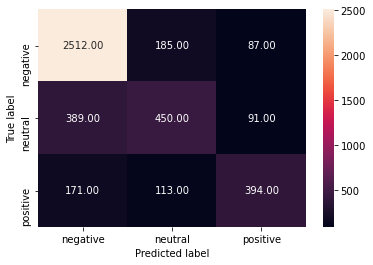

In [29]:
draw_cm( y_test, result )

# TfidfVectorizer

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
data_features = vectorizer.fit_transform(data['text'])

data_features = data_features.toarray()

data_features.shape

(14640, 5000)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=100, n_jobs=8)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(n_jobs=8)
0.7185109289617487


In [32]:
result = forest.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['negative', 'neutral', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


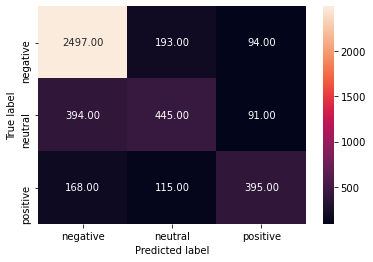

In [33]:
draw_cm( y_test, result )

# Summary and Findings

- We are getting an accuracy of around 72% with both TfidfVectorizer and CountVectorizer